# Kaggle Instant Gratification

[https://www.kaggle.com/c/instant-gratification/overview](https://www.kaggle.com/c/instant-gratification/overview)

- Binary classification (optimization of AUC)
<br/><br/>
- An enigmatic advice:

Silly column names abound,<br/>
but the test set is a mystery.<br/>
Careful how you pick and slice,<br/>
or be left behind by history.

# Import modules

In [25]:
import numpy as np
import pandas as pd
import os

from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import roc_auc_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.mixture import GaussianMixture

from sklearn.ensemble import RandomForestClassifier
#from lightgbm import LGBMClassifier
#import xgboost as xgb

import pandas_profiling # descriptive statistics dataset

%matplotlib inline

# Load data and do descripive statistics

data is available at [https://www.kaggle.com/c/instant-gratification/data](https://www.kaggle.com/c/instant-gratification/data)

In [ ]:
train = pd.read_csv('../data/train.csv') #changer le path : ../input/
test = pd.read_csv('../data/test.csv')

In [141]:
print(train.shape)
print(test.shape)

(262144, 258)
(131073, 257)


In [4]:
train.head()

,id,muggy-smalt-axolotl-pembus,dorky-peach-sheepdog-ordinal,slimy-seashell-cassowary-goose,snazzy-harlequin-chicken-distraction,frumpy-smalt-mau-ordinal,stealthy-beige-pinscher-golden,chummy-cream-tarantula-entropy,hazy-emerald-cuttlefish-unsorted,nerdy-indigo-wolfhound-sorted,...,wheezy-myrtle-mandrill-entropy,wiggy-lilac-lemming-sorted,gloppy-cerise-snail-contributor,woozy-silver-havanese-gaussian,jumpy-thistle-discus-sorted,muggy-turquoise-donkey-important,blurry-buff-hyena-entropy,bluesy-chocolate-kudu-fepid,gamy-white-monster-expert,target
0,707b395ecdcbb4dc2eabea00e4d1b179,-2.070654,1.018160,0.228643,0.857221,0.052271,0.230303,-6.385090,0.439369,-0.721946,...,0.351895,0.618824,-1.542423,0.598175,0.611757,0.678772,0.247059,-0.806677,-0.193649,0
1,5880c03c6582a7b42248668e56b4bdec,-0.491702,0.082645,-0.011193,1.071266,-0.346347,-0.082209,0.110579,-0.382374,-0.229620,...,-0.645115,-1.246090,2.613357,-0.479664,1.581289,0.931258,0.151937,-0.766595,0.474351,0
2,4ccbcb3d13e5072ff1d9c61afe2c4f77,-1.680473,0.860529,-1.076195,0.740124,3.678445,0.288558,0.515875,0.920590,-1.223277,...,0.516422,0.130521,-0.459210,2.028205,-0.093968,-0.218274,-0.163136,-0.870289,0.064038,1
3,e350f17a357f12a1941f0837afb7eb8d,0.183774,0.919134,-0.946958,0.918492,0.862278,1.155287,0.911106,0.562598,-1.349685,...,-1.168967,1.385089,-0.353028,3.316150,-0.524087,-0.794327,3.936365,0.682989,-2.521211,0
4,a8f910ea6075b6376af079055965ff68,-0.203933,-0.177252,0.368074,-0.701320,-1.104391,0.735760,0.894273,-1.375826,-5.144946,...,-0.279168,1.544356,2.959727,1.641201,-0.130818,-0.264292,-0.748668,0.964218,0.087079,0


In [17]:
%%time
profile = pandas_profiling.ProfileReport(train.sample(n=10000))

CPU times: user 1min 19s, sys: 2.29 s, total: 1min 22s
Wall time: 1min 34s


In [41]:
profile.to_file()

Remark :
- a little bit slow on big datasets: here launch on a sample of 10000 obs. only -> about 1 minute

In [13]:
%%time # on peut comparer avec un describe
train.describe()

(262144, 258)

# First model

In [21]:
X_train, X_val, y_train, y_val = train_test_split(train.drop(['id', 'target'], axis=1),
                                                  train['target'].values,
                                                  test_size=0.3,
                                                  random_state=2019)

In [29]:
rf1 = RandomForestClassifier(n_estimators=100,
                             max_depth=10,
                             n_jobs=-1)

In [30]:
rf1.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [31]:
roc_auc_score(y_val, rf1.predict_proba(X_val)[:,1])

0.5312056263862484

# Some more in-depth data exploration

In [37]:
var = [col for col in train.columns if col not in ['id', 'target']]

/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


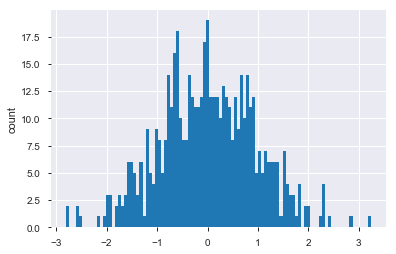

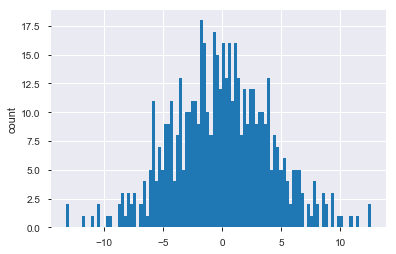

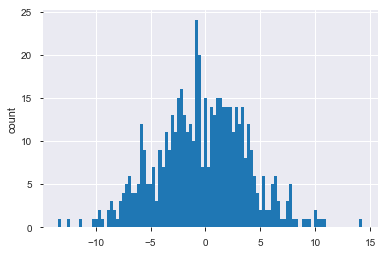

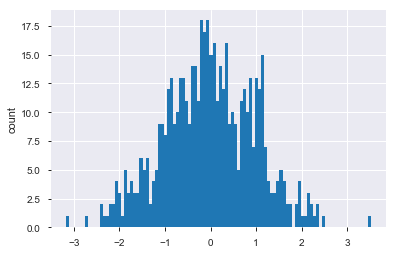

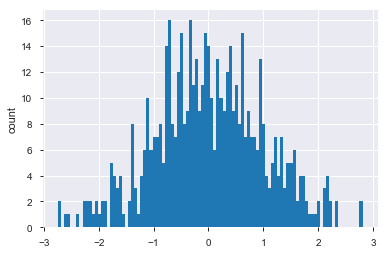

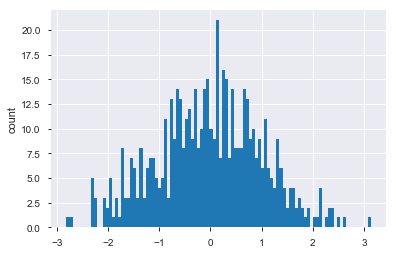

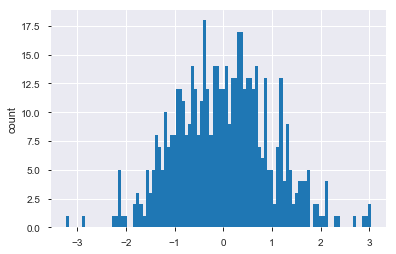

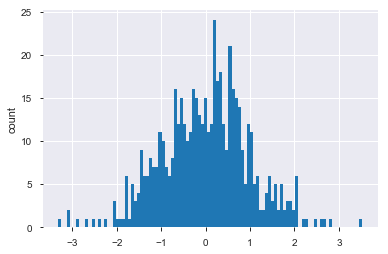

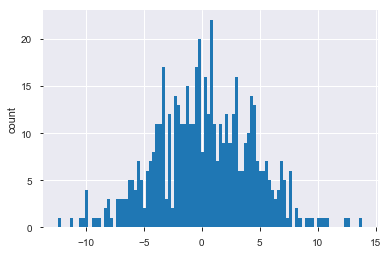

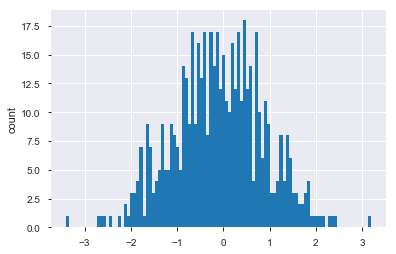

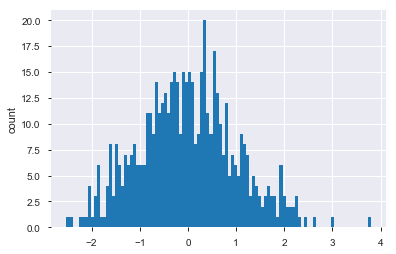

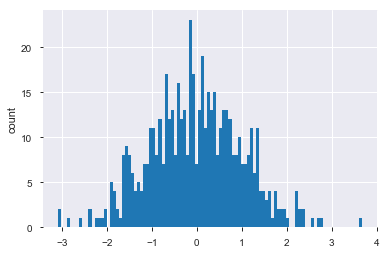

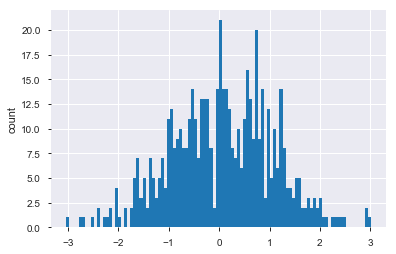

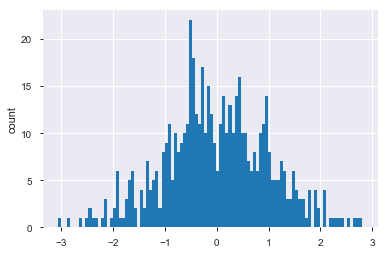

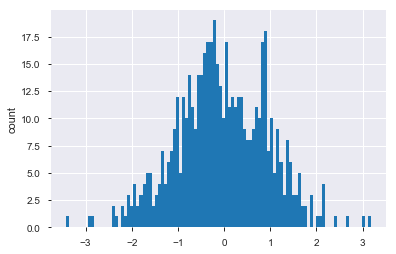

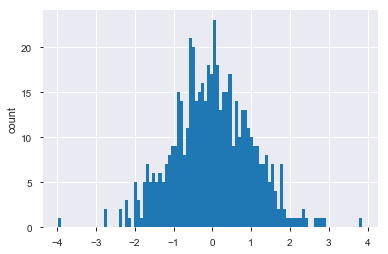

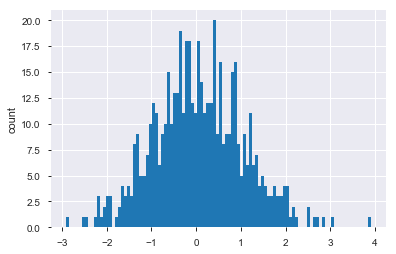

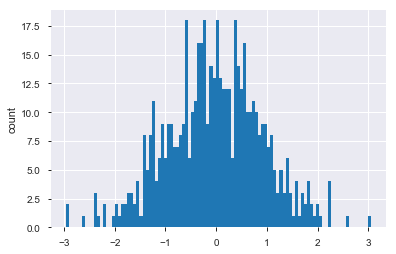

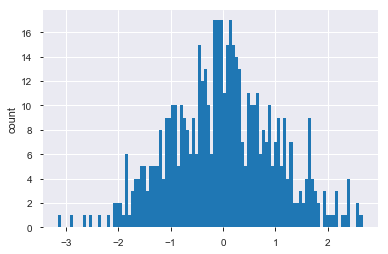

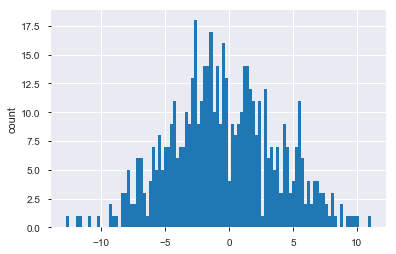

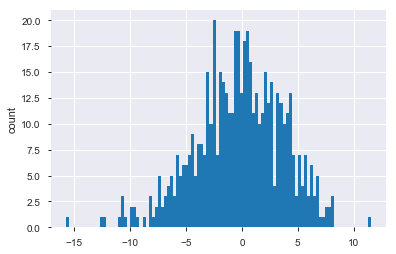

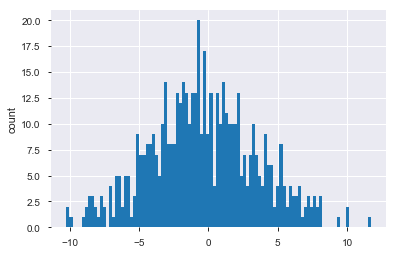

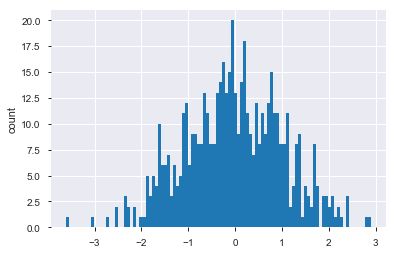

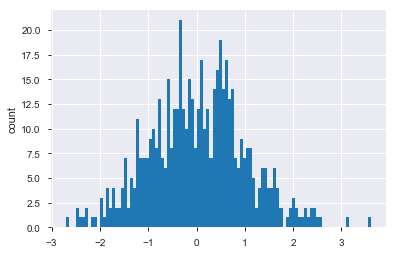

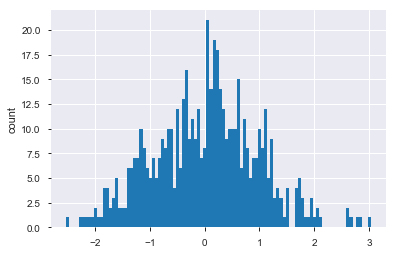

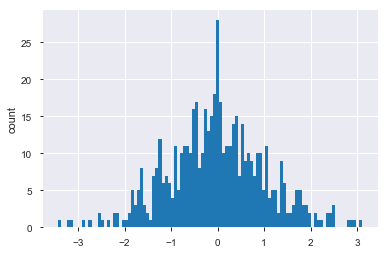

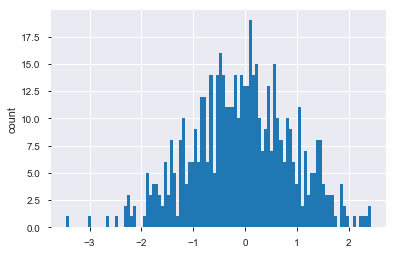

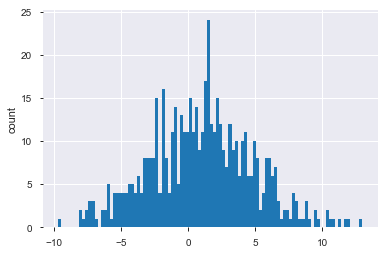

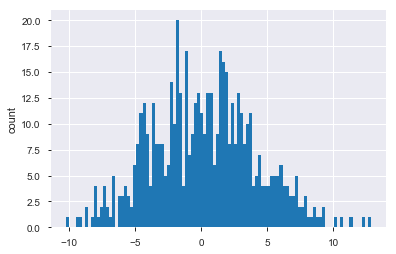

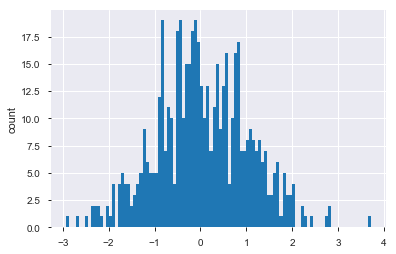

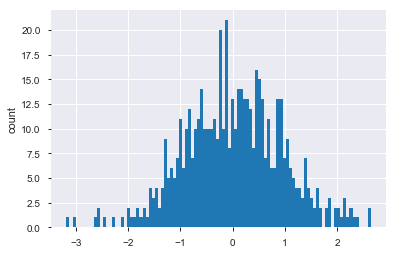

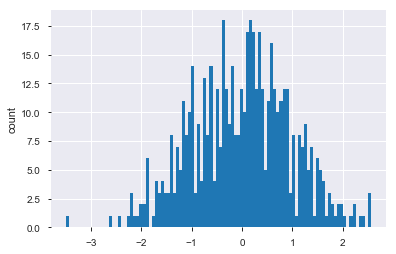

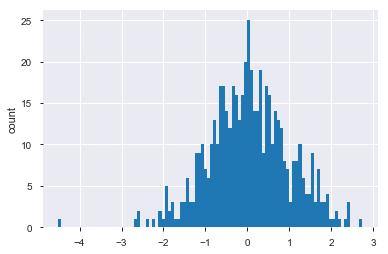

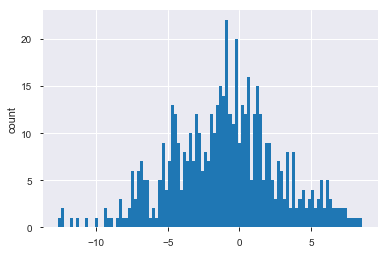

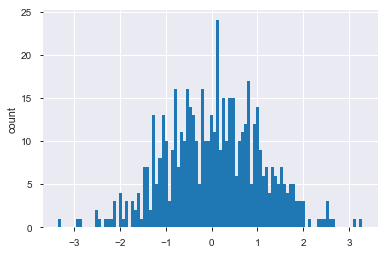

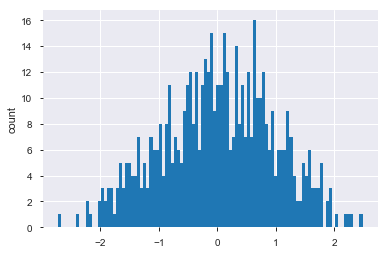

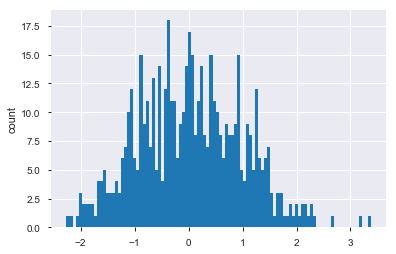

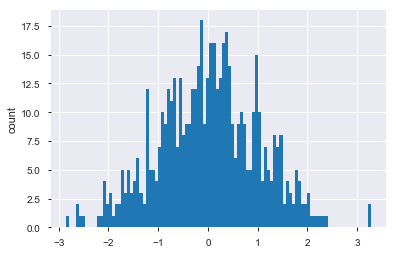

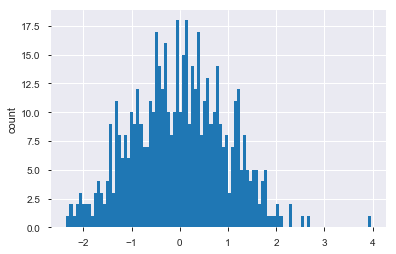

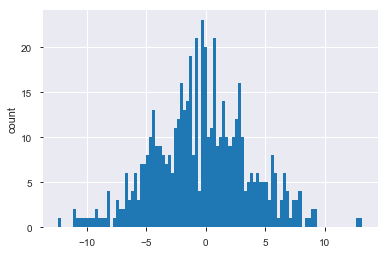

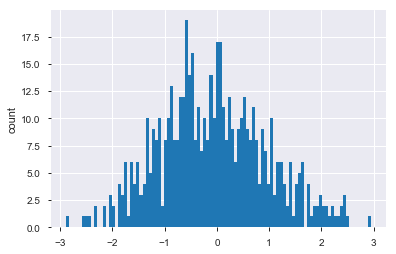

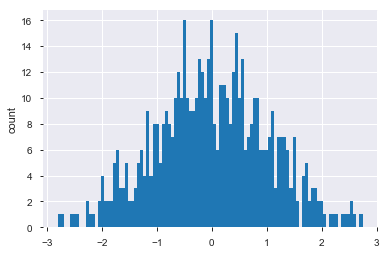

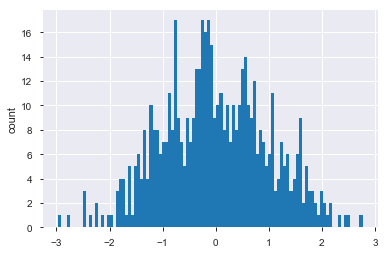

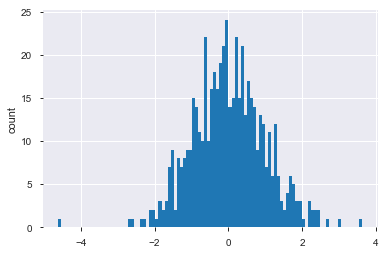

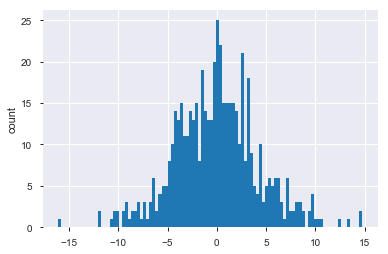

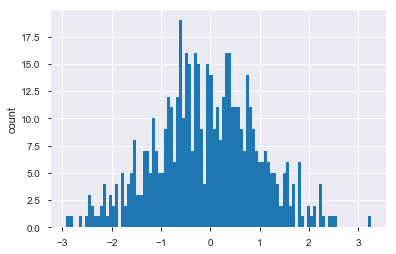

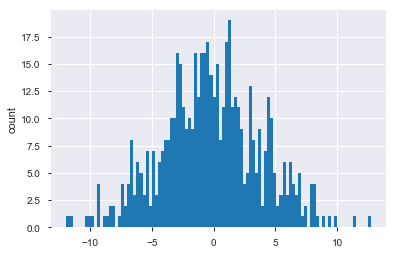

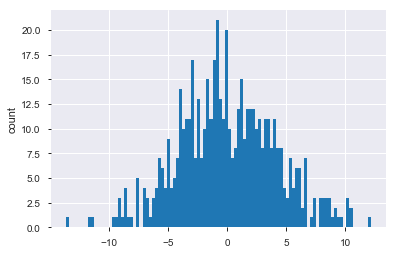

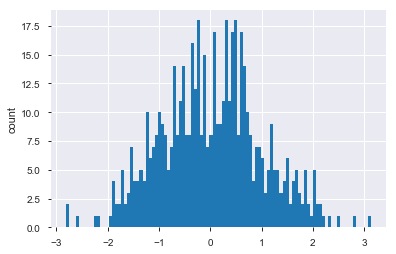

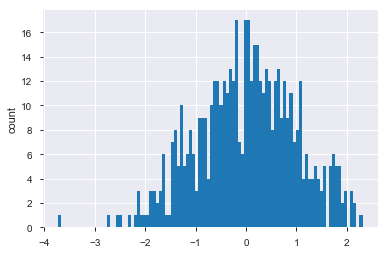

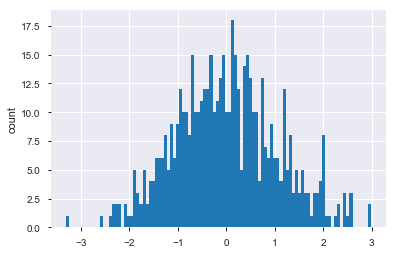

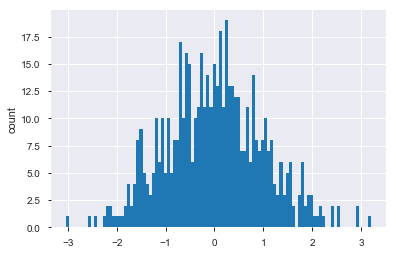

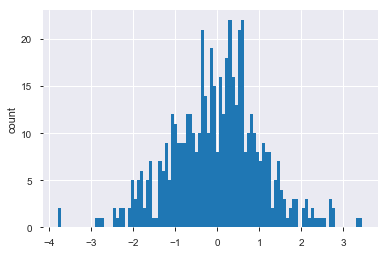

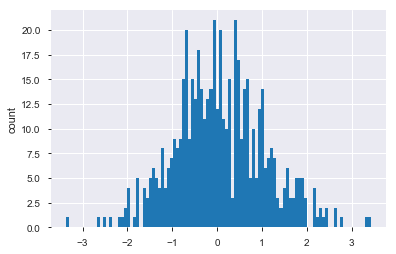

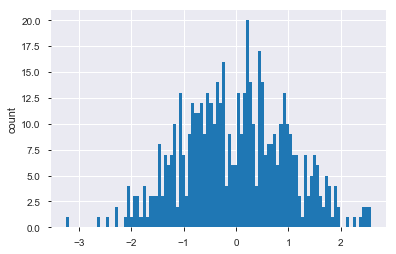

In [39]:
for col in var[200:len(var)]:
    plt.figure()
    plt.hist(b[col], bins=100)
    plt.ylabel('count')

In [42]:
train['wheezy-copper-turtle-magic'].value_counts()

51     570
489    556
298    554
135    554
245    553
50     551
180    547
104    546
126    545
86     545
335    544
299    543
61     543
311    543
76     542
373    541
391    540
441    540
64     539
268    539
452    539
41     539
150    538
3      538
460    538
22     537
444    537
28     537
250    536
367    536
      ... 
244    486
447    486
306    486
14     486
330    486
412    485
115    485
13     485
179    484
503    484
279    484
375    484
32     483
360    483
490    482
157    482
74     482
340    482
11     482
402    480
233    480
85     479
339    478
422    478
501    477
277    476
215    475
108    472
42     471
185    442
Name: wheezy-copper-turtle-magic, Length: 512, dtype: int64

In [38]:
k=0
b = train.loc[train['wheezy-copper-turtle-magic']==k, :]
b.shape()

## Model on one group
### With all variables

In [43]:
X_train, X_val, y_train, y_val = train_test_split(b.drop(['id', 'target'], axis=1),
                                                  b['target'].values,
                                                  test_size=0.3,
                                                  random_state=2019)

In [77]:
rf1 = RandomForestClassifier(n_estimators=100,
                             max_depth=6,
                             n_jobs=-1)

In [78]:
rf1.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [79]:
roc_auc_score(y_val, rf1.predict_proba(X_val)[:,1])

0.7524162371134021

### With "high variance" variables only

In [80]:
a = b[var].drop('wheezy-copper-turtle-magic').apply(np.std, 0)
selected_col = a[a > 2].index
selected_col

Index(['muggy-smalt-axolotl-pembus', 'stealthy-beige-pinscher-golden',
       'hazy-emerald-cuttlefish-unsorted', 'bluesy-rose-wallaby-discard',
       'bumpy-amaranth-armadillo-important', 'dorky-tomato-ragdoll-dataset',
       'flaky-goldenrod-bat-noise', 'chewy-myrtle-wasp-important',
       'slimy-blue-alligator-master', 'hazy-tan-schnauzer-hint',
       'thirsty-gamboge-dragonfly-kernel', 'geeky-amethyst-quetzal-unsorted',
       'homey-scarlet-javanese-novice', 'goopy-copper-fousek-distraction',
       'blurry-sangria-saola-gaussian', 'paltry-seashell-neanderthal-master',
       'crappy-pumpkin-saola-grandmaster', 'flaky-cream-peccary-sorted',
       'pokey-russet-hippopotamus-master', 'slimy-thistle-cuscus-hint',
       'cozy-khaki-reindeer-golden', 'hasty-puce-fowl-fepid',
       'sunny-purple-husky-noise', 'nerdy-teal-olm-fepid',
       'snazzy-purple-donkey-discard', 'cozy-vermilion-uguisu-grandmaster',
       'seedy-chartreuse-whippet-hint', 'ugly-tangerine-llama-goose',
   

In [82]:
X_train, X_val, y_train, y_val = train_test_split(b[selected_col],
                                                  b['target'].values,
                                                  test_size=0.3,
                                                  random_state=2019)

In [83]:
rf1 = RandomForestClassifier(n_estimators=100,
                             max_depth=6,
                             n_jobs=-1)

In [84]:
rf1.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [85]:
roc_auc_score(y_val, rf1.predict_proba(X_val)[:,1])

0.8642074742268041

# Data generated by "make_classification" function in sklearn

```python
NUM_SUB_DATASETS = 512
NUM_SAMPLES = 1024
NUM_FEATURES = 255
MAX_SEED = 2**32 - 1

def create_dataset(random_seed):
    random.seed(3 + random_seed) #setting a seed for the randint() call below
    X,y = make_classification(n_samples=NUM_SAMPLES, 
                             n_features=NUM_FEATURES, 
                             n_informative=random.randint(33,47),
                             n_redundant=0,
                             n_repeated=0,
                             n_classes=2,
                             n_clusters_per_class=3,
                             weights=None,
                             flip_y=0.05,
                             class_sep=1.0,
                             hypercube=True,
                             shift=0.0,
                             scale=1.0,
                             shuffle=True,
                             random_state=random_seed)
    df = funny_names(X)
    df['wheezy-copper-turtle-magic'] = random_seed
    df = df.sample(frac=1, axis=1, random_state=random_seed, replace=False) # Shuffle column order so magic variable isn't last
    df['target'] = y
    return df


seed_list = random.sample(range(1,MAX_SEED), NUM_SUB_DATASETS)
df = pd.concat([create_dataset(s) for s in seed_list], axis=0, sort = False).reset_index(drop=True)
df = df.sample(frac=1, random_state=9726).reset_index(drop=True) # Shuffle rows
```


### Main steps in `make_classification` (for one group !):
- `n_cluster = n_clusters_per_class * n_classes` 
- `for k in range(n_cluster):`
  * Generate `c_k` the cluster centrois randomly on {-1, 1}^p (with p = `n_informative`)
  * `X_k = generator.randn(n_samples, n_informative)`
  * `X_k = np.dot(X_k, A)`, with `A = 2 * generator.rand(n_informative, n_informative) - 1`
  * `X_k += centroid_k`
  * Fill `n_features - n_informative` other columns of k with noise
  * `y_k = 0` for the firsts `n_clusters_per_class` clusters, 1 for the `n_clusters_per_class` following clusters, etc.
  * `flip_y` percent of `y_k` labels are flipped

# Two main algorithms : Quadratic discriminant analysis and Gaussian mixture models

The generated data is generated as a

Other tested models that did not work as well:
    - KNN
    - LDA
    - PCA to reduce the dimension
    - Kmeans

## QDA : Quadratic discriminant analysis (supervised learning)

![gaussian_model_illus1](../images/gaussian_model_illus1.png)

In [95]:
X_train, X_val, y_train, y_val = train_test_split(b[selected_col],
                                                  b['target'].values,
                                                  test_size=0.3,
                                                  random_state=2018)

X_test = train.loc[train['wheezy-copper-turtle-magic']==k, selected_col]

In [96]:
qda = QuadraticDiscriminantAnalysis(reg_param=0.9, store_covariance=True)

In [97]:
qda.fit(X_train, y_train)

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.9,
               store_covariance=True, store_covariances=None, tol=0.0001)

In [98]:
roc_auc_score(y_val, rf1.predict_proba(X_val)[:,1])

0.9683544303797469

## GMM : Gaussian mixture model (unsupervised learning)

### Using it mimicking QDA

In [108]:
X_train, X_val, y_train, y_val = train_test_split(b[selected_col],
                                                  b['target'].values,
                                                  test_size=0.3,
                                                  random_state=2018)

X_test = train.loc[train['wheezy-copper-turtle-magic']==k, selected_col]

In [109]:
def get_mean_cov(x,y):
    ones = (y==1).astype(bool)
    x1 = x[ones]
    cov1 = np.cov(x1.T)
    m1 = np.mean(x1, axis = 0)
    
    onesb = (y==0).astype(bool)
    x0 = x[onesb]
    cov0 = np.cov(x0.T)
    m0 = np.mean(x0, axis = 0)
    
    ms = np.stack([m0,m1])
    ps = np.stack([np.linalg.inv(m) for m in [cov0,cov1]])
    return ms,ps

In [110]:
ms, ps = get_mean_cov(X_train,y_train)

In [117]:
gm = GaussianMixture(n_components=2, covariance_type='full', tol=0.001,
                     reg_covar=0.5, max_iter=100, n_init=1, means_init=ms, precisions_init=ps)

gm.fit(np.concatenate([X_train,X_val,X_test], axis = 0))

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=array([[-0.08711,  0.61321, ...,  0.11612, -0.42026],
       [ 0.16689, -0.80816, ..., -0.60796,  0.50364]]),
        n_components=2, n_init=1,
        precisions_init=array([[[ 0.12157,  0.0223 , ...,  0.03167, -0.012  ],
        [ 0.0223 ,  0.11351, ...,  0.0098 ,  0.00865],
        ...,
        [ 0.03167,  0.0098 , ...,  0.10819, -0.00847],
        [-0.012  ,  0.00865, ..., -0.00847,  0.10289]],

       [[ 0.17853,  0.01821, ..., -0.05104, -0.00488],
        [ 0.01821,  0.12772, ...,  0.01353, -0.00772],
        ...,
        [-0.05104,  0.01353, ...,  0.16218,  0.01114],
        [-0.00488, -0.00772, ...,  0.01114,  0.1132 ]]]),
        random_state=None, reg_covar=0.5, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [118]:
roc_auc_score(y_val, gm.predict_proba(X_val)[:,1])

0.9535350416795307

### Using it the right way

#### 3 clusters per class !
![images_3_clusters](../images/gaussian_model_illus_3clusters.jpg)

In [127]:
n_init = 100
n_cluster = 3
reg_covar = 0.5

gm1 = GaussianMixture(n_components=n_cluster, covariance_type='full', tol=0.001, init_params ='kmeans',
                      reg_covar=reg_covar, weights_init=np.ones(n_cluster)/n_cluster,
                      n_init=n_init, max_iter=100) #, means_init=ms, precisions_init=ps

gm1.fit(X_train.loc[y_train == 1,:])

gm0 = GaussianMixture(n_components=n_cluster, covariance_type='full', tol=0.001, init_params ='kmeans',
                      reg_covar=reg_covar, weights_init=np.ones(n_cluster)/n_cluster,
                      n_init=n_init, max_iter=100)
gm0.fit(X_train.loc[y_train == 0,:])

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=3, n_init=100, precisions_init=None,
        random_state=None, reg_covar=0.5, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False,
        weights_init=array([0.33333, 0.33333, 0.33333]))

In [128]:
gm = GaussianMixture(n_components=2*n_cluster, covariance_type='full', tol=0.001,
                     reg_covar=reg_covar, n_init=100, max_iter=100,
                     means_init= np.concatenate((gm0.means_, gm1.means_), axis = 0),
                     precisions_init=np.concatenate((gm0.precisions_, gm1.precisions_),
                                                    axis = 0))

In [129]:
gm.fit(np.concatenate((X_train, X_val, X_test), axis=0))

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=array([[ 1.14255,  1.05126, ..., -0.01771, -1.24495],
       [-1.89828,  1.14616, ..., -0.2102 , -0.82281],
       ...,
       [ 0.19923, -1.61188, ...,  1.26053,  3.36943],
       [-0.05425, -0.67084, ..., -1.48511, -0.09017]]),
        n_components=6, n_init=100,
        precisions_init=array([[[ 4.51645e-01,  7.56116e-02, ..., -3.45957e-03, -1.15792e-01],
        [ 7.56116e-02,  2.22189e-01, ...,  1.02628e-02,  5.31908e-02],
        ...,
        [-3.45957e-03,  1.02628e-02, ...,  3.87244e-01, -1.36303e-01],
        [-1.15792e-01,  5.31908e-02, ..., -1.36303e-01,  4...1.89034e-01,  7.53657e-03],
        [ 4.62466e-04, -2.46456e-02, ...,  7.53657e-03,  1.40308e-01]]]),
        random_state=None, reg_covar=0.5, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [130]:
# not clear that it is better when ran on a single group
roc_auc_score(y_val, gm.predict_proba(X_val)[:,n_cluster:].sum(axis=1) / gm.predict_proba(X_val)[:,:n_cluster].sum(axis=1))

0.9513738808274158

# Comparing the scores of both approaches on all the groups

## GMM 1cluster

In [136]:
# Parameters
reg_covar = 0.5
n_cluster = 1
n_init = 5 # need to limit number of init kmeans

cols = [c for c in train.columns if c not in ['id', 'target']]
cols.remove('wheezy-copper-turtle-magic')
oof_gm = np.zeros(len(train))
#oof_gm2 = np.zeros(len(train))

#preds_gm = np.zeros(len(test_s))
#oof_full = np.zeros((len(train), n_cluster*2))
#preds_full = np.zeros((len(test_s), n_cluster*2))

# BUILD 512 SEPARATE MODELS
for i in tqdm(range(512)):
    # ONLY TRAIN WITH DATA WHERE WHEEZY EQUALS i
    train2 = train[train['wheezy-copper-turtle-magic']==i]
    test2 = test[test['wheezy-copper-turtle-magic']==i]
    idx1 = train2.index
    idx2 = test2.index
    train2.reset_index(drop=True,inplace=True)
    
    # FEATURE SELECTION WITH Standard deviation (USE APPROX 40 OF 255 FEATURES)
    sel = VarianceThreshold(threshold=1.5).fit(train2[cols])
    train3 = sel.transform(train2[cols])
    test3 = sel.transform(test2[cols])
    
    # STRATIFIED K-FOLD
    skf = StratifiedKFold(n_splits=11, random_state=60, shuffle=True)
    for train_index, val_index in skf.split(train3, train2['target']):
        
        ms, ps = get_mean_cov(train3[train_index,:],train2.loc[train_index]['target'].values)
        
        gm = GaussianMixture(n_components=2, covariance_type='full', tol=0.001,
                             reg_covar=0.5, max_iter=100, n_init=n_init,
                             means_init=ms, precisions_init=ps)

        gm.fit(np.concatenate([train3,test3], axis = 0))

        oof_gm[idx1[val_index]] = gm.predict_proba(train3[val_index,:])[:,1]
        



  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 1/512 [00:02<23:35,  2.77s/it]

  0%|          | 2/512 [00:04<19:57,  2.35s/it]

  1%|          | 3/512 [00:05<16:48,  1.98s/it]

  1%|          | 4/512 [00:06<14:18,  1.69s/it]

  1%|          | 5/512 [00:07<12:23,  1.47s/it]

  1%|          | 6/512 [00:08<11:02,  1.31s/it]

  1%|▏         | 7/512 [00:08<09:50,  1.17s/it]

  2%|▏         | 8/512 [00:10<09:28,  1.13s/it]

  2%|▏         | 9/512 [00:10<08:50,  1.05s/it]

  2%|▏         | 10/512 [00:12<09:08,  1.09s/it]

  2%|▏         | 11/512 [00:13<09:44,  1.17s/it]

  2%|▏         | 12/512 [00:14<09:54,  1.19s/it]

  3%|▎         | 13/512 [00:15<09:31,  1.15s/it]

  3%|▎         | 14/512 [00:16<08:45,  1.06s/it]

  3%|▎         | 15/512 [00:17<08:17,  1.00s/it]

  3%|▎         | 16/512 [00:18<08:05,  1.02it/s]

  3%|▎         | 17/512 [00:19<08:01,  1.03it/s]

  4%|▎         | 18/512 [00:20<09:01,  1.10s/it]

  4%|▎         | 19/512 [00:21<08:31,  1.04s/it]

  4%|▍         |

 56%|█████▋    | 288/512 [05:21<03:33,  1.05it/s]

 56%|█████▋    | 289/512 [05:22<03:25,  1.08it/s]

 57%|█████▋    | 290/512 [05:23<03:18,  1.12it/s]

 57%|█████▋    | 291/512 [05:25<03:50,  1.04s/it]

 57%|█████▋    | 292/512 [05:26<03:44,  1.02s/it]

 57%|█████▋    | 293/512 [05:26<03:32,  1.03it/s]

 57%|█████▋    | 294/512 [05:28<03:46,  1.04s/it]

 58%|█████▊    | 295/512 [05:28<03:29,  1.04it/s]

 58%|█████▊    | 296/512 [05:29<03:21,  1.07it/s]

 58%|█████▊    | 297/512 [05:30<03:33,  1.01it/s]

 58%|█████▊    | 298/512 [05:31<03:37,  1.02s/it]

 58%|█████▊    | 299/512 [05:32<03:40,  1.04s/it]

 59%|█████▊    | 300/512 [05:33<03:36,  1.02s/it]

 59%|█████▉    | 301/512 [05:34<03:33,  1.01s/it]

 59%|█████▉    | 302/512 [05:35<03:18,  1.06it/s]

 59%|█████▉    | 303/512 [05:36<03:10,  1.10it/s]

 59%|█████▉    | 304/512 [05:37<03:19,  1.04it/s]

 60%|█████▉    | 305/512 [05:38<03:34,  1.03s/it]

 60%|█████▉    | 306/512 [05:39<03:27,  1.01s/it]

 60%|█████▉    | 307/512 [05:40

In [137]:
print(roc_auc_score(train['target'], oof_gm))

0.9675630092147526


## GMM 3 clusters

In [138]:
# Parameters
reg_covar = 0.5
n_cluster = 3
n_init = 5 # need to limit number of init kmeans

cols = [c for c in train.columns if c not in ['id', 'target']]
cols.remove('wheezy-copper-turtle-magic')
oof_gm = np.zeros(len(train))
oof_gm2 = np.zeros(len(train))

#preds_gm = np.zeros(len(test_s))
oof_full = np.zeros((len(train), n_cluster*2))
#preds_full = np.zeros((len(test_s), n_cluster*2))

# BUILD 512 SEPARATE MODELS
for i in tqdm(range(512)):
    # ONLY TRAIN WITH DATA WHERE WHEEZY EQUALS i
    train2 = train[train['wheezy-copper-turtle-magic']==i]
    test2 = test[test['wheezy-copper-turtle-magic']==i]
    idx1 = train2.index
    idx2 = test2.index
    train2.reset_index(drop=True,inplace=True)
    
    # FEATURE SELECTION WITH Standard deviation (USE APPROX 40 OF 255 FEATURES)
    sel = VarianceThreshold(threshold=1.5).fit(train2[cols])
    train3 = sel.transform(train2[cols])
    test3 = sel.transform(test2[cols])
    
    
    # STRATIFIED K-FOLD
    skf = StratifiedKFold(n_splits=11, random_state=60, shuffle=True)
    for train_index, val_index in skf.split(train3, train2['target']):
                
        #ms, ps = get_mean_cov(train3[train_index,:],train2.loc[train_index]['target'].values)
        
        gm1 = GaussianMixture(n_components=n_cluster, covariance_type='full', tol=0.001, init_params ='kmeans',
                              reg_covar=reg_covar, weights_init=np.ones(n_cluster)/n_cluster,
                              n_init=n_init, max_iter=100) #, means_init=ms, precisions_init=ps

        train4 = train3[train_index,:]
        #print((train2.iloc[train_index,:]['target'] == 1))
        gm1.fit(train4[(train2.iloc[train_index,:]['target'] == 1),:])
        
        gm0 = GaussianMixture(n_components=n_cluster, covariance_type='full', tol=0.001, init_params ='kmeans',
                              reg_covar=reg_covar, weights_init=np.ones(n_cluster)/n_cluster,
                              n_init=n_init, max_iter=100)
        gm0.fit(train4[(train2.iloc[train_index,:]['target'] == 0)])
        
        gm = GaussianMixture(n_components=2*n_cluster, covariance_type='full', tol=0.001,
                             reg_covar=reg_covar, n_init=10, max_iter=100,
                             means_init= np.concatenate((gm0.means_, gm1.means_), axis = 0),
                             precisions_init=np.concatenate((gm0.precisions_, gm1.precisions_),
                                                             axis = 0))
        gm.fit(np.concatenate((train3, test3), axis=0))
        
        
        #preds2 = gm.predict_proba(test3)[:,1]
        oof_full[idx1[val_index], :] = gm.predict_proba(train3[val_index,:])
        oof_gm[idx1[val_index]] = gm.predict_proba(train3[val_index,:])[:,n_cluster:].max(axis=1) / gm.predict_proba(train3[val_index,:])[:,:n_cluster].max(axis=1)
        oof_gm2[idx1[val_index]] = gm.predict_proba(train3[val_index,:])[:,n_cluster:].sum(axis=1) / gm.predict_proba(train3[val_index,:])[:,:n_cluster].sum(axis=1)
        #preds_gm[idx2] += preds2 / skf.n_splits
        



  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 1/512 [00:12<1:48:57, 12.79s/it]

  0%|          | 2/512 [00:19<1:34:02, 11.06s/it]

  1%|          | 3/512 [00:30<1:32:45, 10.93s/it]

  1%|          | 4/512 [00:37<1:23:44,  9.89s/it]

  1%|          | 5/512 [00:47<1:23:16,  9.86s/it]

  1%|          | 6/512 [00:55<1:17:53,  9.24s/it]

  1%|▏         | 7/512 [01:03<1:15:41,  8.99s/it]

  2%|▏         | 8/512 [01:13<1:16:18,  9.08s/it]

  2%|▏         | 9/512 [01:21<1:14:42,  8.91s/it]

  2%|▏         | 10/512 [01:29<1:10:46,  8.46s/it]

  2%|▏         | 11/512 [01:39<1:16:15,  9.13s/it]

  2%|▏         | 12/512 [01:48<1:16:09,  9.14s/it]

  3%|▎         | 13/512 [01:56<1:13:11,  8.80s/it]

  3%|▎         | 14/512 [02:04<1:09:49,  8.41s/it]

  3%|▎         | 15/512 [02:13<1:11:05,  8.58s/it]

  3%|▎         | 16/512 [02:20<1:06:28,  8.04s/it]

  3%|▎         | 17/512 [02:29<1:10:04,  8.49s/it]

  4%|▎         | 18/512 [02:36<1:05:28,  7.95s/it]

  4%|▎         | 19/512 [02:44

 56%|█████▌    | 285/512 [40:01<42:50, 11.32s/it]

 56%|█████▌    | 286/512 [40:08<37:13,  9.88s/it]

 56%|█████▌    | 287/512 [40:15<34:10,  9.11s/it]

 56%|█████▋    | 288/512 [40:26<35:31,  9.51s/it]

 56%|█████▋    | 289/512 [40:37<37:22, 10.06s/it]

 57%|█████▋    | 290/512 [40:45<34:43,  9.39s/it]

 57%|█████▋    | 291/512 [40:52<31:34,  8.57s/it]

 57%|█████▋    | 292/512 [40:57<27:44,  7.57s/it]

 57%|█████▋    | 293/512 [41:02<24:45,  6.78s/it]

 57%|█████▋    | 294/512 [41:10<25:42,  7.08s/it]

 58%|█████▊    | 295/512 [41:16<24:41,  6.83s/it]

 58%|█████▊    | 296/512 [41:21<23:01,  6.40s/it]

 58%|█████▊    | 297/512 [41:27<22:05,  6.17s/it]

 58%|█████▊    | 298/512 [41:37<26:17,  7.37s/it]

 58%|█████▊    | 299/512 [41:44<26:00,  7.33s/it]

 59%|█████▊    | 300/512 [41:53<26:58,  7.64s/it]

 59%|█████▉    | 301/512 [41:58<25:01,  7.12s/it]

 59%|█████▉    | 302/512 [42:05<24:09,  6.90s/it]

 59%|█████▉    | 303/512 [42:11<23:38,  6.79s/it]

 59%|█████▉    | 304/512 [42:20

In [140]:
print(roc_auc_score(train['target'].values, oof_gm))
print(roc_auc_score(train['target'].values, oof_gm2))

0.9748145087115295
0.9748153891607868


Other tested techniques without success :
- Analysis of correlations : between the variables, between the lines
- Optimization of AUC with XGboost (objective = 'rankPairwise')
- Look for the seeds used to generate the dataset !
- Optimize the hyperparameters of QDA/GMM (regularization)

Difficulties of the challenge:
- geometrical problem but hard to make graphical representations of the problem because of high dimension
- a lot of things tried without success

Autres stratégies qui fonctionnaient sur ce problème :
- (with QDA) pseudo labelling : use a first model to predict and 

# What should I have done to win ?

1. Identify from the data, with no doubts, that there was 3 clusters per class
2. Figured out that with a GMM with 3 clusters per, the model gave a perfect prediction (ignoring the flipped labels)
3. Find tricks to maximize the score given the proportion of flipped labels and the fact that GMM gave the perfect predictions